# PSF
## Profiles and Encircled Energy
Examples plotting the profiles and encircled energies for Gaussian and Moffat profiles

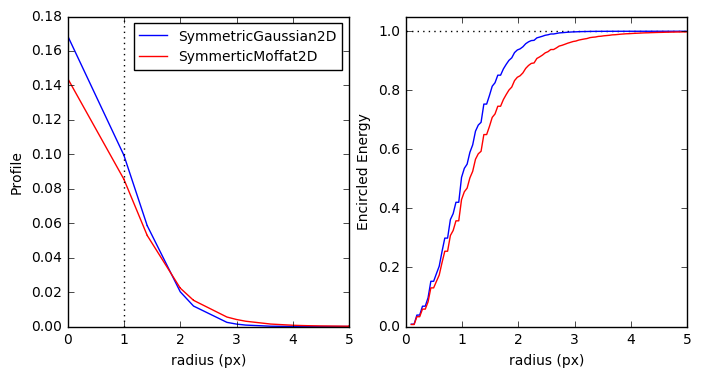

In [10]:
from jfit.psf import SymmetricMoffat2D, SymmetricGaussian2D
import numpy as np
import matplotlib.pyplot as plt

# values to use for the PSF
factor = 10   # oversampling factor
fwhm = 2.
hpw = 5       # patch half-width for 2D patches

# PSF
p1 = SymmetricGaussian2D(x_0=hpw,y_0=hpw,fwhm=fwhm)
p2 = SymmetricMoffat2D(x_0=hpw,y_0=hpw,fwhm=fwhm,alpha=5.)
p1.oversample_factor(factor)
p2.oversample_factor(factor)

fig = plt.figure(figsize=(8,4))

# plot profiles
ax = fig.add_subplot(121)

# test grid to generate PSF
nx,ny = 2*hpw+1,2*hpw+1
y, x = np.mgrid[:nx, :ny]

# radius array
r = np.sqrt( (x-p1.x_0)**2 + (y-p1.y_0)**2 ).flatten()
i = np.argsort(r)

# calculate PSFs over grid
z1 = p1(x,y)
z2 = p2(x,y)

ax.plot(r[i],z1.flatten()[i],'b-',label='SymmetricGaussian2D')
ax.plot(r[i],z2.flatten()[i],'r-',label='SymmerticMoffat2D')
ax.axvline(0.5*fwhm,color='k',ls=':')
ax.set_xlabel('radius (px)')
ax.set_ylabel('Profile')
ax.legend(loc=0,numpoints=1,prop={'size':10})
ax.set_xlim((0,hpw))

# plot EE
ax = fig.add_subplot(122)

# radius array to calculate EE over
r = np.linspace(0.1,hpw,100)
ee1 = p1.ee(r,hpw)
ee2 = p2.ee(r,hpw)

ax.axhline(1.,color='k',ls=':')
ax.plot(r,ee1,'b-')
ax.plot(r,ee2,'r-')
ax.set_xlabel('radius (px)')
ax.set_ylabel('Encircled Energy')
ax.set_ylim((0,1.05))
plt.show()
plt.close()

## Moffat2D

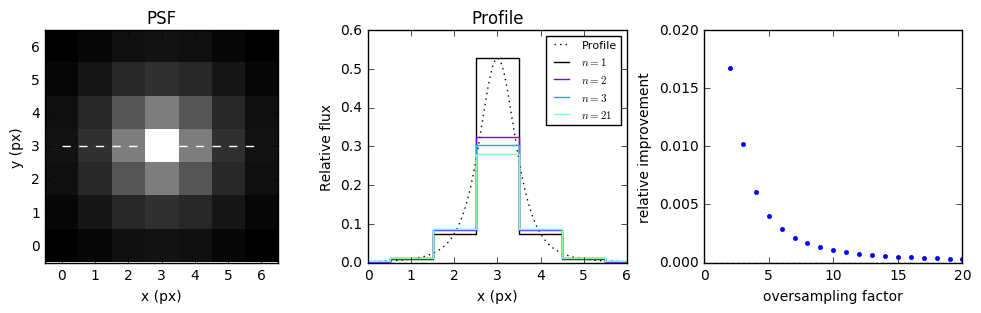

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from jfit.psf import SymmetricMoffat2D


# patch half width and maximum oversampling factor to study
hpw = 3
maxsamp = 21

# psf model to study
p = SymmetricMoffat2D(x_0=hpw,y_0=hpw,fwhm=1,alpha=2)

# pixel grid for evaluating PSF
nx,ny = 2*hpw+1,2*hpw+1
y, x = np.mgrid[:nx, :ny]

# plot the 2D PSF
fig = plt.figure(figsize=(12,3))
fig.subplots_adjust(hspace=0.3,wspace=0.3)
ax = fig.add_subplot(131)
k  = p(x,y)
ax.imshow(k**0.3,interpolation='nearest',origin='lower',cmap='gray')
ax.set_title('PSF')
ax.set_xlabel('x (px)')
ax.set_ylabel('y (px)')

# plot the theoretical PSF profile by generating a PSF with the
# highest subsampling factor and extract the profile from this.
xx,yy = p._oversample_input(x,y,maxsamp)
dx,dy = xx[0,1] - xx[0,0],yy[1,0] - yy[0,0]
kk = p._oversampled_model(x,y,maxsamp,
          p.amplitude.value,p.x_0.value,p.y_0.value,p.fwhm.value,p.alpha.value)

# mark the position of the central value in the oversampled image
x_1 = int((p.x_0+0.5)*maxsamp - 0.5)
y_1 = int((p.y_0+0.5)*maxsamp - 0.5)
ax.plot(xx[y_1,:],yy[y_1,:],'w--')
ax.set_xlim((-0.5,nx-0.5))
ax.set_ylim((-0.5,ny-0.5))

# plot the profile along the x-axis for the pixel that goes through the
# center of the PSF
if maxsamp % 2:
    hs = (maxsamp-1)/2 # assuming maxsamp is odd
else:
    hs = (maxsamp+1)/2

ax = fig.add_subplot(132)

# this plots the profile values of along y=hpw marked by the dotted line
# in the first panel
# ax.plot(xx[y_1,:],kk[y_1,:]*maxsamp*maxsamp,color='k',ls=':',label='Profile')
ax.plot(xx[y_1,:],kk[y_1,:]/(dx*dy),color='k',ls=':',label='Profile')

# below we sum over all over sampled pixels to the original resolution of
# the image
# ax.plot(xx[x_1,:],kk[:,x_1-hs:x_1+hs].sum(-1)*maxsamp,'k-')

# calculate the sum of the PSF w.r.t to no over sampling
facto = np.linspace(1,maxsamp,maxsamp)
maxiter = 4
color = iter(cm.rainbow(np.linspace(0,1,maxiter+1)))
c = 'k'
delta = []
for n in facto:
    p.oversample_factor(n)
    if n < maxiter:
        ax.step(x[hpw,:],p(x,y)[:,hpw],where='mid',color=c,label='$n=%d$'%(n))
        c = next(color)
    
    kk = p._oversample_model(x,y,n,
          p.amplitude.value,p.x_0.value,p.y_0.value,p.fwhm.value,p.alpha.value)
    delta.append((k.sum()-kk.sum())/k.sum())

# plot the highest over sampling
ax.step(x[hpw,:],p(x,y)[:,hpw],where='mid',color=c,label='$n=%d$'%(n))

ax.legend(loc=1,ncol=1,prop={'size':8})
ax.set_ylabel('Relative flux')
ax.set_xlabel('x (px)')
ax.set_title('Profile')

# convert the delta to a relative improvement over the preceding 
# oversampling factor
delta = np.array(delta)
delta = (delta[1:] - delta[:-1])/(delta[1:])

ax = fig.add_subplot(133)
ax.plot(facto[:-1],delta,marker='.',ls='')
ax.axhline(0.,color='k',ls=':')
ax.set_ylabel('relative improvement')
ax.set_xlabel('oversampling factor')
ax.set_ylim((0.,0.02))
#ax.axhline(0.01,color='k',ls=':')
#ax.imshow(kk,interpolation='nearest',origin='lower')

plt.show()
plt.close()

The first panel (PSF) above shows the Moffat profile in the original resolution.

The second panel shows the pixel values for different oversampling factors ($n=1,2,3,21$) along the intersection indicated by the dashed line in the PSF panel.  The dotted line in the background is the profile along this line for the highest oversampling factor before rebinning back to the original resolution (i.e. close to the theoretical profile).  For $n=1$ we see that the binned values are simply drawn from the central values of the theoretical profile for each bin, while for higher sampling factor the average is calculated in each bin to conserve the surface brightness.  Keep in mind that this is a 1D represenation of the 2D profile, which explains why for example the central bin appears higher than what is suggested by the figure.

The third panel is showing how the relative improvement in the total flux of the profile with respect to the previous oversampling factor.

# Sersic

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from jfit.models import Sersic2D

# setup grid
hpw = 10
nx,ny = 2*hpw+1,2*hpw+1
y, x = np.mgrid[:nx, :ny]

s = Sersic2D(x_0=hpw,y_0=hpw,n=2,r_eff=0.5*hpw)
ss = s(x,y)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(ss**0.25,vmin=0.,vmax=np.max(ss**0.25),origin='lower',cmap='gray')
plt.show()
plt.close()

# Convolution
Illustrate the effect of image convolution

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from jfit.psf import SymmetricGaussian2D

def xy_data(nx=5,ny=7):
    # generate data
    y, x = np.mgrid[:nx, :ny]
    return x,y

s = (31,61)
fwhmi = 7
factor = 5
i = SymmetricGaussian2D(x_0=(s[1]-1)/2,y_0=(s[0]-1)/2,fwhm=fwhmi)
i.oversample_factor(factor)

# assign Gaussian kernel
fwhmk = 5
khpw = 2*fwhmk        # kernel half-width
k = SymmetricGaussian2D(fwhm=fwhmk)
i.set_kernel(k,khpw)

# evaluate model
x,y = xy_data(s[0],s[1])
m = i(x,y)

# extract 1D slice
mmax = m.max()
mask = m == mmax
x0,y0 = x[mask],y[mask]
zz,xx = m[y0,:].ravel(),x[y0,:].ravel()

# fit 1D Gaussian to slice
# Fit the data using a Gaussian
g_init = models.Gaussian2D(amplitude=zz.max(), x_mean=(s[1]-1)/2, y_mean=(s[0]-1)/2,
                           x_stddev=fwhmi,y_stddev=fwhmi)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y, m)
print g

# plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.step(xx,zz,where='mid',color='k',label='Image slice')

gi = models.Gaussian1D(amplitude=g.amplitude.value, mean=g.x_mean.value, stddev=stddevi)
tx = np.linspace(xx.min(),xx.max(),300)
ax.plot(tx,gi(tx),color='r',ls='-',label='Original image PSF')

stddevi,stddevk = fwhmi/2.35,fwhmk/2.35
stddevt = np.sqrt(stddevi**2 + stddevk**2)
gt = models.Gaussian1D(amplitude=g.amplitude.value, mean=g.x_mean.value, stddev=stddevt)
ax.plot(tx,gt(tx),color='b',ls='-',label='Fitted Gaussian to the image')
ax.legend(loc=1,numpoints=1,prop={'size':8})
ax.set_xlabel('x (px)')
ax.set_ylabel('counts')

print "Relative difference between theoretical sigma and fitted: %.2f"%((g.x_stddev.value-stddevi)/stddevi)

plt.show()
plt.close()